# <center>Project 4 -- Predicting Salaries for Data Science Job-Seekers</center>
## <center>Importing Data and EDA</center>

In [1]:
import requests
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, f1_score
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
import pandas as pd
from lxml import html
import bs4
from bs4 import BeautifulSoup
import urllib2
import re
import patsy 
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, LogisticRegressionCV
from sklearn.cross_validation import train_test_split, cross_val_score
import math
from sklearn import preprocessing, svm
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for salary > $84,999', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    
def plot_roc(ya_true, ya_score):
    fpr, tpr, _ = roc_curve(ya_true, ya_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')

In [1]:
# # Reading in the file and having a look at the how many rows and columns it contains.
df = pd.read_csv('/Users/smoot/Desktop/indeed-scraped-job-postings.csv')
df.shape

In [87]:
# Looking at the first few rows to see what the data set looks like.
df.head(3)

,city,company,salary,summary,title,parsed_salary
0,San+Francisco,MarkMonitor,"$180,000 a year","Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0
1,San+Francisco,Workbridge Associates,"$130,000 - $180,000 a year",3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0
2,San+Francisco,Mines.io,"$80,000 - $120,000 a year",We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0


In [88]:
'''Looking for how many unique cities are in the data set.  There are five cities: San Francisco, New York, Chicago,
Austin and Seattle.  We can also see which city has the most job postings.  We must be aware, in our case, that there
are many duplicate rows and these numbers may not be a real indicator of a city having a large surplus of data
science jobs.'''

print df['city'].unique()
print df.city.value_counts()

['San+Francisco' 'New+York' 'Austin' 'Seattle' 'Chicago']
Austin           2681
Chicago          1175
New+York          441
San+Francisco     405
Seattle            89
Name: city, dtype: int64


In [89]:
# Looks like there is a '+' between two-word city names.  Lets remove that and add a space.
df['city'] = df['city'].str.replace('+', ' ')

In [90]:
''''Looking at the unique companies in the data set.  Looks like there are an unusual amount of jobs at the University 
of Texas at Austin, probably because this data set is pretty crummy ;-)'''

print pd.unique(df['company'].ravel())
print df.company.value_counts()

['MarkMonitor' 'Workbridge Associates' 'Mines.io' 'Smith Hanley Associates'
 'HSF Consulting' 'All-In Analytics' 'Brilent' 'Jobspring Partners'
 'University of California Berkeley' 'Corporate Labs Technology' '3coast'
 'NextGen Jane, Inc.' 'Talent Compliance Consulting Services'
 'California State University' 'Analytic Recruiting' 'LT' 'Galvanize'
 'AllianceBernstein' 'Empiric Solutions' 'Wade & Wendy'
 "ADMIN FOR CHILDREN'S SVCS" 'Selby Jennings' 'Technical Source'
 'Datacom Technology Group' 'HRA/DEPT OF SOCIAL SERVICES'
 'TalentHub Worldwide' 'Smart Host' 'Princeton Consulting'
 'DEPT OF HEALTH/MENTAL HYGIENE' 'Infinity Consulting Solutions'
 'Oliver James Associates' 'Execsolution, Inc.' 'Averity' 'Helix Sleep'
 'Insurance Fund, State' 'Health Research Incorporated'
 'Research Foundation of The City University of New...' 'ingenium'
 'NJF Search' 'Atrium Staffing' 'DEPT OF ENVIRONMENT PROTECTION'
 'DEPARTMENT OF FINANCE' 'HOUSING PRESERVATION & DVLPMNT'
 'The Big Game Hunter' 'OFFIC

In [91]:
'''Looking over unique salary values.  We will need to multiply some salaries by 12 since they are listed as a per
month wage.  Also it appears that there is an entry where the salary is listed as a per day wage.  This entry has one
duplicate.  Converting a per day wage into a yearly salary (how many days a week did they work? Did they work holidays?)
seems overly complex so we are going to simply remove them from the data set. '''

pd.unique(df.salary.ravel())
df.salary.unique().ravel()
df[df.isnull().any(axis=1)]

,city,company,salary,summary,title,parsed_salary
438,New York,Selby Jennings,$650 - $900 a day,Senior Quantitative Developer/Machine Learning...,Senior Quantitative/Machine Learning - Contract,NaN
456,New York,Selby Jennings,$650 - $900 a day,Senior Quantitative Developer/Machine Learning...,Senior Quantitative/Machine Learning - Contract,NaN


In [2]:
''''It looks like there are several summaries that repeat many times.  We have decided to leave these duplicate entries 
in our data set.''''

pd.unique(df['summary'].ravel())
print df['summary'].value_counts()

In [93]:
# Looking at the unique entries in title.  They appear to match the amount of duplicates in other columns.

df.title.value_counts()
pd.unique(df.title.ravel())

array(['Data Scientist', 'Senior Data Scientist',
       'Full-Stack Data Scientist', 'VP of Data Services',
       'Fraud Data Scientist', 'Python Developer (Machine Learning)',
       'Staff Research Associate, PMB',
       'Chief Algorithm Developer (Signal Processing) - Wearables',
       'Post-Doctoral Scholar-Employee: Analysis of omics data',
       'Principal Data Scientist', 'Data Scientist (Econometrics)',
       'Data Scientist (Statistics/Economics)',
       'Data Scientist (Machine Learning)',
       'Senior NLP Scientist/Engineer',
       'Senior Data Scientist (Autonomous Vehicle Research)',
       'VP - Predictive Modeling / Data Scientist',
       'Database Administrator, GSE', 'Scientific Researcher',
       'Vice President Engineering (Big Data/ Machine Learning)',
       'Quality Control Scientist',
       'Administrative Analyst/Specialist, Exempt I - Office of Rese...',
       'Senior Data Scientist (Python, R, recommendation)',
       'Data Scientist (Natural Lan

In [94]:
''''Now we are looking at the 'parsed_salary' column.  We already know there are two null values.  We can also see that 
the values in this column are not all yearly salaries. If the 'salary' column had a clear cut salary listed it went nicely 
into 'parsed_salary.'  If it was a range, the middle point of the range ended up in 'parsed_salary.'  If it was a 
salary by month it is likely to be below $10,000.  We can simply multiply such values by 12 to get something resembling
an annual salary.  We do not know how benefits will be calculated into such cases yet we decided to disregard that and 
have decided to treat them the same. '''

print df.parsed_salary.value_counts()
print pd.unique(df.parsed_salary)

5950.0      788
3210.0      783
8541.5      699
85000.0     396
170000.0    393
82329.0     389
130000.0    369
137500.0    357
150000.0    347
5098.0       35
120000.0     15
76941.5      14
140000.0     13
200000.0      8
100000.0      7
65000.0       7
145000.0      6
64055.5       5
185000.0      5
160000.0      5
135000.0      5
75000.0       5
190000.0      4
3438.5        4
180000.0      4
175000.0      4
125000.0      4
90000.0       4
3611.0        3
8124.5        3
           ... 
59984.5       1
8333.0        1
41000.0       1
3524.5        1
57500.0       1
6388.0        1
47406.0       1
51363.0       1
71000.0       1
4966.0        1
53875.0       1
4714.0        1
4459.0        1
71568.0       1
250000.0      1
49012.0       1
47799.5       1
45000.0       1
55200.0       1
225000.0      1
76897.5       1
110000.0      1
3466.0        1
49222.5       1
3361.0        1
52500.0       1
80000.0       1
60000.0       1
2500.0        1
97866.5       1
Name: parsed_salary, dty

In [95]:
# Now let's get rid of the null values in our 'parsed_salary' column.

df.isnull().sum()
df.dropna(inplace = True)

In [96]:
# This salary column doesn't seem to have much use anymore.  Let's replace it with the 'parsed_salary' column.

df['salary'] = df['parsed_salary']
del df['parsed_salary']

In [97]:
# Did it work?  Yes! Beautiful.

df.head(1)

,city,company,salary,summary,title
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist


In [98]:
# Now lets multiply any value that we've deemed to be a monthly salary by 12 in order to make it an annual salary. 

df['salary'] = df['salary'].apply(lambda x: x*12 if (x < 10000) else x)

In [99]:
# df.to_csv('Data_Science_Jobs_one.csv')

In [100]:
# Checking the minimum $ amount in salary.  Almost 30K, looks like a pretty crummy, but plausable, annual salary.

df.salary.min()

27996.0

In [101]:
# Now we are going to calculate the median of our 'salary' column.  We will use this value to split our salaries in half.

np.median(df.salary)

85000.0

#  <center>Model No. 1--Logistic Regression</center>

In [104]:
''''First we need to create a new column with salary as a 0 or 1.  Anything below 85000 = 0, everything else = 1.  
We also need our variables in 'city' to become quantifiable so we will use the patsy function to accomplish this.'''

df['salary_b'] = [0 if i < 85000  else 1 for i in df.salary]
X = patsy.dmatrix('city -1', df)
y = df['salary_b']

In [105]:
# Train, test, split.  We split our data into quarters.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state = 7)

In [106]:
# Instantiating the instance of our function for Logistic Regression and fitting the model to our training set. 

lm = LogisticRegression()
logreg = lm.fit(X_train, y_train)

In [107]:
# Let's take a look at the predicted scores and coefficients.

y_pred = logreg.predict(X_test)
print lm.coef_, y_pred

[[-1.10116841 -0.13030682  1.20908187  2.83330387 -2.04958527]] [1 0 0 ..., 0 1 0]


In [108]:
print lm.score(X_test, y_test)

0.691986644407


In [109]:
# Cross validating our score.  It looks like our score is reliable.

score = cross_val_score(logreg, X_test, y_test, cv = 5)
score

array([ 0.70954357,  0.69583333,  0.66108787,  0.71966527,  0.67364017])

# <center>Model No. 2</center>
<center>For Model No. 2 we will split our target, salary, into 3 categories as ('salary_m')</center>

In [110]:
''''Here we are making our dependent variable into 3 categories but running the same model.  
Let's name this 'salary_m', for multi-class. Steps that were described in Model No. 1 will not be repeatedly described
unless there is a deviation, in which case it will be noted.'''

df['salary_m'] = [0 if i < 70000 else 2 if i > 130000  else 1 for i in df.salary]
df.head(1)

,city,company,salary,summary,title,salary_b,salary_m
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,1,2


In [111]:
# Here we use label encoder to encode our new variable 'salary_m'.

le = preprocessing.LabelEncoder()
le.fit(df['salary_m'])
Y = df['salary_m']

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify = Y, random_state = 42)

In [113]:
logreg_two = lm.fit(X_train, Y_train)

In [114]:
Y_pred = logreg_two.predict(X_test)

In [115]:
Y_pred

array([0, 1, 2, ..., 2, 1, 1])

In [116]:
print lm.score(X_test, Y_test)

0.735171261487


In [117]:
logreg_two_score = cross_val_score(logreg_two, X_test, Y_test, cv = 5)
logreg_two_score

array([ 0.73858921,  0.72916667,  0.72384937,  0.74895397,  0.73529412])

# <center>Model No. 3 -- Multinomial Logistic Regression</center>

In [118]:
# Create a position_level column which will contain categorized data for the Title.  This step was described above.

def generatePositionLevel(title):
    title = title.lower()
    if (title.find('manager',0,len(title)) >= 0) or (title.find('management',0,len(title)) >= 0):
        return 'manager'
    elif (title.find('senior',0,len(title)) >= 0) or (title.find('vp',0,len(title)) >= 0) or (title.find('director',0,len(title)) >= 0):
        return 'senior'
    else:    
        return 'other'
    
df['position_level'] = df['title'].apply(generatePositionLevel)
df.head(2)

,city,company,salary,summary,title,salary_b,salary_m,position_level
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,1,2,other
1,San Francisco,Workbridge Associates,155000.0,3+ years of industry experience in a data scie...,Senior Data Scientist,1,2,senior


In [119]:
Xs = patsy.dmatrix('city + position_level -1', df)
Ys = df['salary_b']
ys

In [120]:
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs, Ys, test_size=0.25, stratify = Ys, random_state = 7)
mlogreg = lm.fit(Xs_train, Ys_train)
Ys_pred = mlogreg.predict(Xs_test)

In [121]:
Ys_pred

array([1, 0, 0, ..., 0, 1, 0])

In [122]:
print mlogreg.score(Xs_test, Ys_test)

0.834724540902


In [123]:
score = cross_val_score(mlogreg, Xs_test, Ys_test, cv = 5)
print score

[ 0.85062241  0.81666667  0.82426778  0.84518828  0.82426778]


# <center>Model No. 4</center>

In [124]:
# Create skill columns which will contain binary data for the Skills.

def generateSkills(jobDescription, skill):
    jobDescription = jobDescription.lower()
    skill = skill.lower()
    if jobDescription.find(skill) >= 0:
        return 1
    return 0

# We limited the skills columns to python, sql and machine learning

df['skill_python'] = [generateSkills(x,'python') for x in df.summary]
df['skill_sql'] = [generateSkills(x,'sql') for x in df.summary]
df['skill_machine_learning'] = [generateSkills(x,'machine learning') for x in df.summary]
df.head(2)

,city,company,salary,summary,title,salary_b,salary_m,position_level,skill_python,skill_sql,skill_machine_learning
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,1,2,other,0,1,1
1,San Francisco,Workbridge Associates,155000.0,3+ years of industry experience in a data scie...,Senior Data Scientist,1,2,senior,1,0,0


In [125]:
Xa = patsy.dmatrix('city + position_level + skill_python + skill_sql + skill_machine_learning -1', df)
ya = df['salary_b']

lm = LogisticRegression(penalty='l2')
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size = .25, stratify = ya, random_state = 3)
skills = lm.fit(Xa_train, ya_train)
ya_pred = skills.predict(Xa_test)

In [126]:
print skills.score(Xa_test, ya_test)

0.847245409015


In [127]:
skills_score = cross_val_score(skills, Xa_test, ya_test, cv = 5)
print skills_score

[ 0.85062241  0.84583333  0.85774059  0.83682008  0.82845188]


In [128]:
# Not sure how to interpret this.

print lm.coef_

[[-0.48897653 -0.95350088 -0.24498699  1.0487791  -1.33331021  1.68276404
   7.34344937  1.71103181 -0.05714276  1.21115039]]


In [129]:
lrcv = LogisticRegressionCV(Cs = 15)
lrcv = lrcv.fit(Xa_test, ya_test)

In [130]:
lrcv_pred = lrcv.predict(Xa_test)
print lrcv.score(Xa_test, ya_test), lrcv_pred

0.85225375626 [0 1 0 ..., 0 0 1]


#  <center>Model No. 4 -- ROC Curve & Confusion Matrix</center>

In [131]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [132]:
''''Below we can see how our predictions did.  It looks like we only had 1 false negative, which is pretty good.  We did 
have a lot of false positives but we've decided we can live with that.'''

cm = np.array(confusion_matrix(ya_test, ya_pred))
confusion = pd.DataFrame(cm, index=['under_85K', 'over_85K'],
                         columns=['predicted_under_85K','predicted_over_85K'])
confusion

,predicted_under_85K,predicted_over_85K
under_85K,526,1
over_85K,182,489


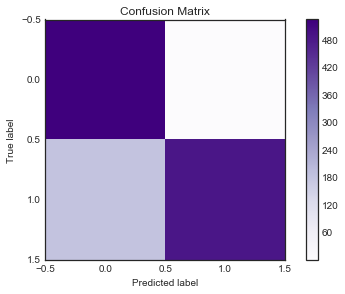

In [133]:
# Here is a graphical representation of the confusion matrix. 

plt.figure()
plot_confusion_matrix(cm)

In [134]:
TP = confusion.ix['under_85K', 'predicted_under_85K']
FP = confusion.ix['over_85K', 'predicted_under_85K']
TN = confusion.ix['over_85K', 'predicted_over_85K']
FN = confusion.ix['under_85K', 'predicted_over_85K']
print TP, FP, TN, FN

526 182 489 1


In [135]:
''''Let's take a look at our scores.  It looks like we are really quite precise.  We could improve our accuracy but since
our data set is so skewed we will settle for these results.  Hip Hip Hooray!'''

print accuracy_score(ya_test, ya_pred)
print precision_score(ya_test, ya_pred)
print recall_score(ya_test, ya_pred)
print f1_score(ya_test, ya_pred)

0.847245409015
0.997959183673
0.728763040238
0.842377260982


In [136]:
''''This is interesting.  If you change the probability you can see how it would affect our confusion matrix.  If you 
move it all the way up to .99 (so the decision will be made with only 99% certainty you only get an additional 
77 more FP but no more FN.  '''

ya_pp = pd.DataFrame(skills.predict_proba(Xa_test), columns=['under_85K_pp','over_85K_pp'])
ya_pp['over_85K_high_thresh'] = [1 if x >= .99 else 0 for x in ya_pp.over_85K_pp.values]
conmat_high = np.array(confusion_matrix(ya_test, ya_pp.over_85K_high_thresh.values))
confusion_high = pd.DataFrame(conmat_high, index=['under_85K', 'over_85K'],
                         columns=['predicted_under_85K','predicted_over_85K'])

confusion_high

,predicted_under_85K,predicted_over_85K
under_85K,526,1
over_85K,264,407


In [137]:
ya_pp

,under_85K_pp,over_85K_pp,over_85K_high_thresh
0,0.685294,0.314706,0
1,0.002174,0.997826,1
2,0.949093,0.050907,0
3,0.685294,0.314706,0
4,0.685294,0.314706,0
5,0.007521,0.992479,1
6,0.007521,0.992479,1
7,0.011915,0.988085,0
8,0.685294,0.314706,0
9,0.011915,0.988085,0


In [138]:
# We have a pretty good ROC AUC score here.  This is the area under the curve.  It's nearly 89%.

ya_score = skills.decision_function(Xa_test)

In [139]:
classifier = svm.SVC(kernel='linear', C=0.01)
ya_pred = classifier.fit(Xa_train, ya_train).predict(Xa_test)

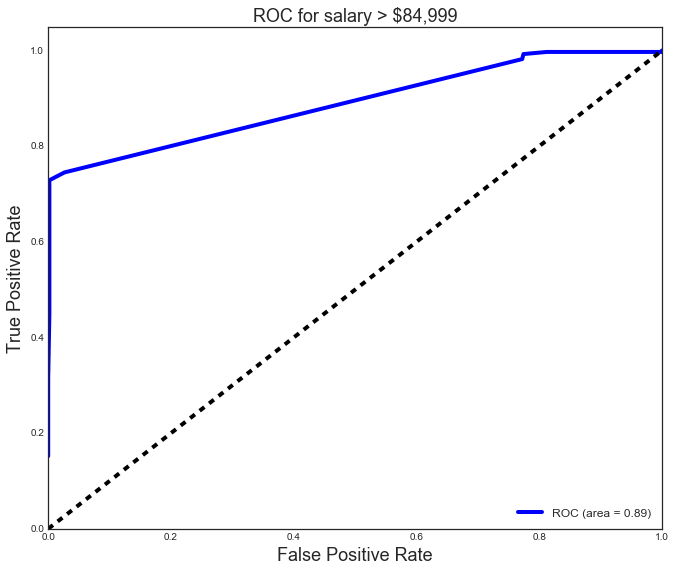

In [140]:
# Let's have a look at our ROC curve.  It looks pretty cool if you ask me.  

plot_roc(ya_test, ya_score)
plt.show()

In [141]:
roc_auc_score = roc_auc_score(ya_test, ya_score)
roc_auc_score

0.88986530624941673

In [142]:
# Unfortunately we are still pretty bad at interpreting coefficients so we will save that for Project 5!

print np.corrcoef(Xa_test)

[[ 1.         -0.32732684 -0.16666667 ...,  0.375       1.         -0.25      ]
 [-0.32732684  1.          0.50917508 ..., -0.32732684 -0.32732684
   0.21821789]
 [-0.16666667  0.50917508  1.         ..., -0.16666667 -0.16666667
  -0.16666667]
 ..., 
 [ 0.375      -0.32732684 -0.16666667 ...,  1.          0.375      -0.25      ]
 [ 1.         -0.32732684 -0.16666667 ...,  0.375       1.         -0.25      ]
 [-0.25        0.21821789 -0.16666667 ..., -0.25       -0.25        1.        ]]


In [143]:
# Here is a classification report.

target_names = ['below 85K', 'above 85K']
print classification_report(ya_test, ya_pred, target_names = target_names)

             precision    recall  f1-score   support

  below 85K       0.74      1.00      0.85       527
  above 85K       1.00      0.72      0.84       671

avg / total       0.88      0.84      0.84      1198



In [144]:
# grid search and ridge regularization.  Probably still need help in intrepreting what I'm doing here.

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
model = Ridge()
skills_grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
skills_grid.fit(Xa, ya)
print skills_grid

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [145]:
#Summarize the Results of the Grid Search

print skills_grid.best_score_
print skills_grid.best_estimator_

0.283785172824
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


# <center>Model No. 5 --kNN (k Nearest Neighbor)</center>

In [146]:
from sklearn import datasets, neighbors, metrics
import pandas as pd

In [147]:
Xss_train, Xss_test, Yss_train, Yss_test = train_test_split(Xs, Ys, test_size=0.33, stratify = Ys, random_state = 7)

In [148]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(Xss_train, Yss_train)

print knn.predict(Xss_test)
print knn.score(Xss_test, Yss_test)

[0 1 0 ..., 0 0 0]
0.839342188488
